In [19]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import config
from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import pickle

#Import Data

In [2]:
#load credentials
credentials = service_account.Credentials.from_service_account_file(config.credentials)
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

#save data to datafram
sql = """
select
  *
from `fantasy-football-415601.fantasy_football.player_by_season`
where fantpos = 'RB'
"""
df = client.query(sql).to_dataframe()

#Clean data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              783 non-null    int64  
 1   rank               783 non-null    int64  
 2   player             783 non-null    object 
 3   tm                 783 non-null    object 
 4   fantpos            783 non-null    object 
 5   age                783 non-null    int64  
 6   g                  783 non-null    int64  
 7   gs                 783 non-null    int64  
 8   passing_cmp        783 non-null    float64
 9   passing_att        783 non-null    float64
 10  passing_yds        783 non-null    float64
 11  passing_td         783 non-null    float64
 12  passing_int        783 non-null    float64
 13  rushing_att        783 non-null    float64
 14  rushing_yds        783 non-null    float64
 15  rushing_yds_att    783 non-null    float64
 16  rushing_td         783 non

#Running Backs

In [4]:
rb = (
    df.loc[:,['player','ppr','g','gs','rushing_att','rushing_yds_att','rushing_td','rushing_yds_g','rushing_att_g','rushing_td_g','receiving_tgt',
            'receiving_yds_rec','receiving_yds_g','receiving_tgt_g','receiving_rec_g','receiving_td_g','fmb','fl','td','td_g','age','posrank','season']]
)

In [5]:
rb.head()

,player,ppr,g,gs,rushing_att,rushing_yds_att,rushing_td,rushing_yds_g,rushing_att_g,rushing_td_g,...,receiving_tgt_g,receiving_rec_g,receiving_td_g,fmb,fl,td,td_g,age,posrank,season
0,Chris Thompson,93.6,11,0,37.0,3.73,0.0,12.545455,3.363636,0.0,...,5.272727,3.818182,0.0,1.0,0.0,0,0.0,29,61,2019
1,Jalen Richard,82.8,16,0,39.0,3.72,0.0,9.062500,2.437500,0.0,...,2.687500,2.250000,0.0,2.0,0.0,0,0.0,26,65,2019
2,Giovani Bernard,68.4,16,2,53.0,3.21,0.0,10.625000,3.312500,0.0,...,2.687500,1.875000,0.0,2.0,1.0,0,0.0,28,73,2019
3,Ty Johnson,60.2,16,1,63.0,4.33,0.0,17.062500,3.937500,0.0,...,1.937500,1.500000,0.0,1.0,1.0,0,0.0,22,77,2019
4,Mark Walton,42.0,7,4,53.0,3.79,0.0,28.714286,7.571429,0.0,...,3.000000,2.142857,0.0,1.0,1.0,0,0.0,22,81,2019


In [7]:
rb.describe()

,ppr,g,gs,rushing_att,rushing_yds_att,rushing_td,rushing_yds_g,rushing_att_g,rushing_td_g,receiving_tgt,...,receiving_tgt_g,receiving_rec_g,receiving_td_g,fmb,fl,td,td_g,age,posrank,season
count,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,...,783.000000,783.000000,783.000000,783.000000,783.00000,783.000000,783.000000,783.000000,783.000000,783.000000
mean,76.291954,10.781609,3.524904,73.357599,3.568020,2.288633,24.734364,5.851876,0.181488,20.799489,...,1.630884,1.258333,0.045721,0.784163,0.44189,2.909323,0.227209,25.329502,83.273308,2020.996169
std,85.051535,5.227516,5.148841,82.046380,1.894875,3.347857,25.141914,5.511262,0.261558,23.741078,...,1.586584,1.255765,0.091607,1.199170,0.80050,3.952170,0.299088,2.679129,50.597928,1.399209
min,-4.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,-12.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,21.000000,1.000000,2019.000000
25%,7.850000,6.000000,0.000000,8.000000,2.890000,0.000000,3.721154,1.000000,0.000000,2.000000,...,0.333333,0.214286,0.000000,0.000000,0.00000,0.000000,0.000000,23.000000,40.000000,2020.000000
50%,42.700000,12.000000,1.000000,38.000000,3.970000,1.000000,15.666667,4.000000,0.071429,12.000000,...,1.200000,1.000000,0.000000,0.000000,0.00000,1.000000,0.125000,25.000000,80.000000,2021.000000
75%,125.200000,16.000000,5.000000,119.000000,4.590000,3.000000,43.235417,9.966667,0.285714,33.500000,...,2.500000,2.000000,0.066667,1.000000,1.00000,4.000000,0.375000,27.000000,126.500000,2022.000000
max,471.200000,17.000000,17.000000,378.000000,10.000000,18.000000,126.687500,27.375000,2.000000,142.000000,...,8.875000,7.250000,1.000000,7.000000,5.00000,21.000000,2.000000,37.000000,189.000000,2023.000000


Many of the stats do not have a normal distribution. This makes sense as many active players may not get a lot of snaps. We'll need to exclude outliers.

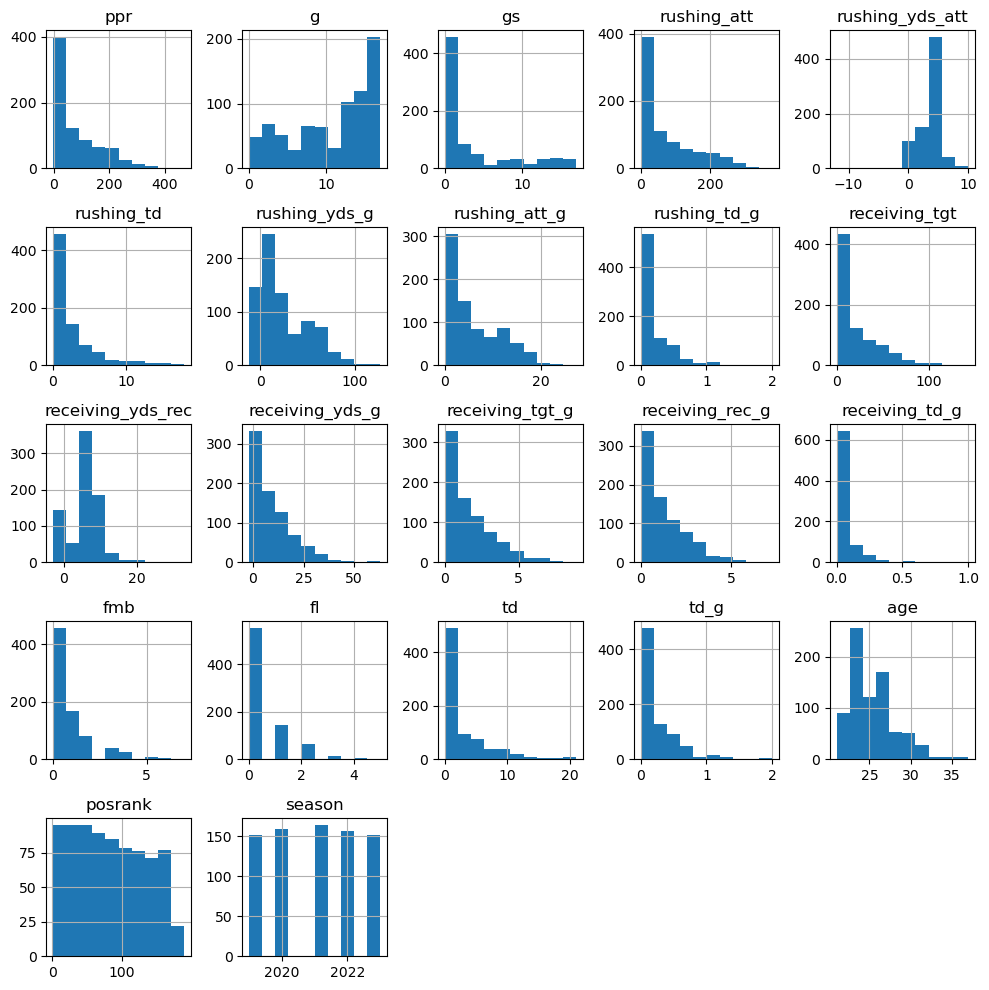

In [6]:
rb.hist(bins=10, figsize=(10, 10))
plt.tight_layout()
plt.show()

There are several columns with high correlation which we should consider dropping. Let's leave the per game metrics and exclude the totals, as it will be more helpful when analyzing player performance during the season.

<Axes: >

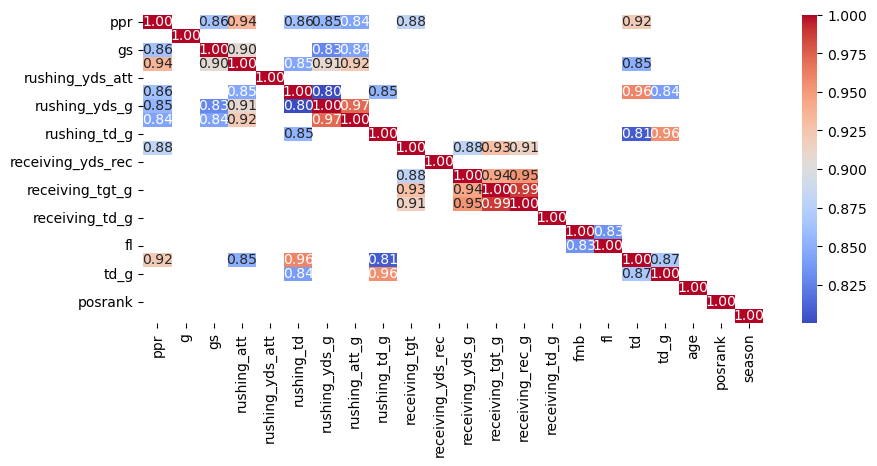

In [7]:
corr_matrix = rb.drop(columns=['player']).corr()
mask = corr_matrix.map(lambda x: x < 0.8 and x != 1)

plt.figure(figsize=(10, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

In [8]:
#select just per game metrics
rb_g = rb.loc[:,['player','ppr','g','gs','rushing_yds_att','rushing_yds_g','rushing_att_g','rushing_td_g',
                'receiving_yds_rec','receiving_rec_g','receiving_yds_g','receiving_tgt_g','receiving_td_g','age','posrank']]

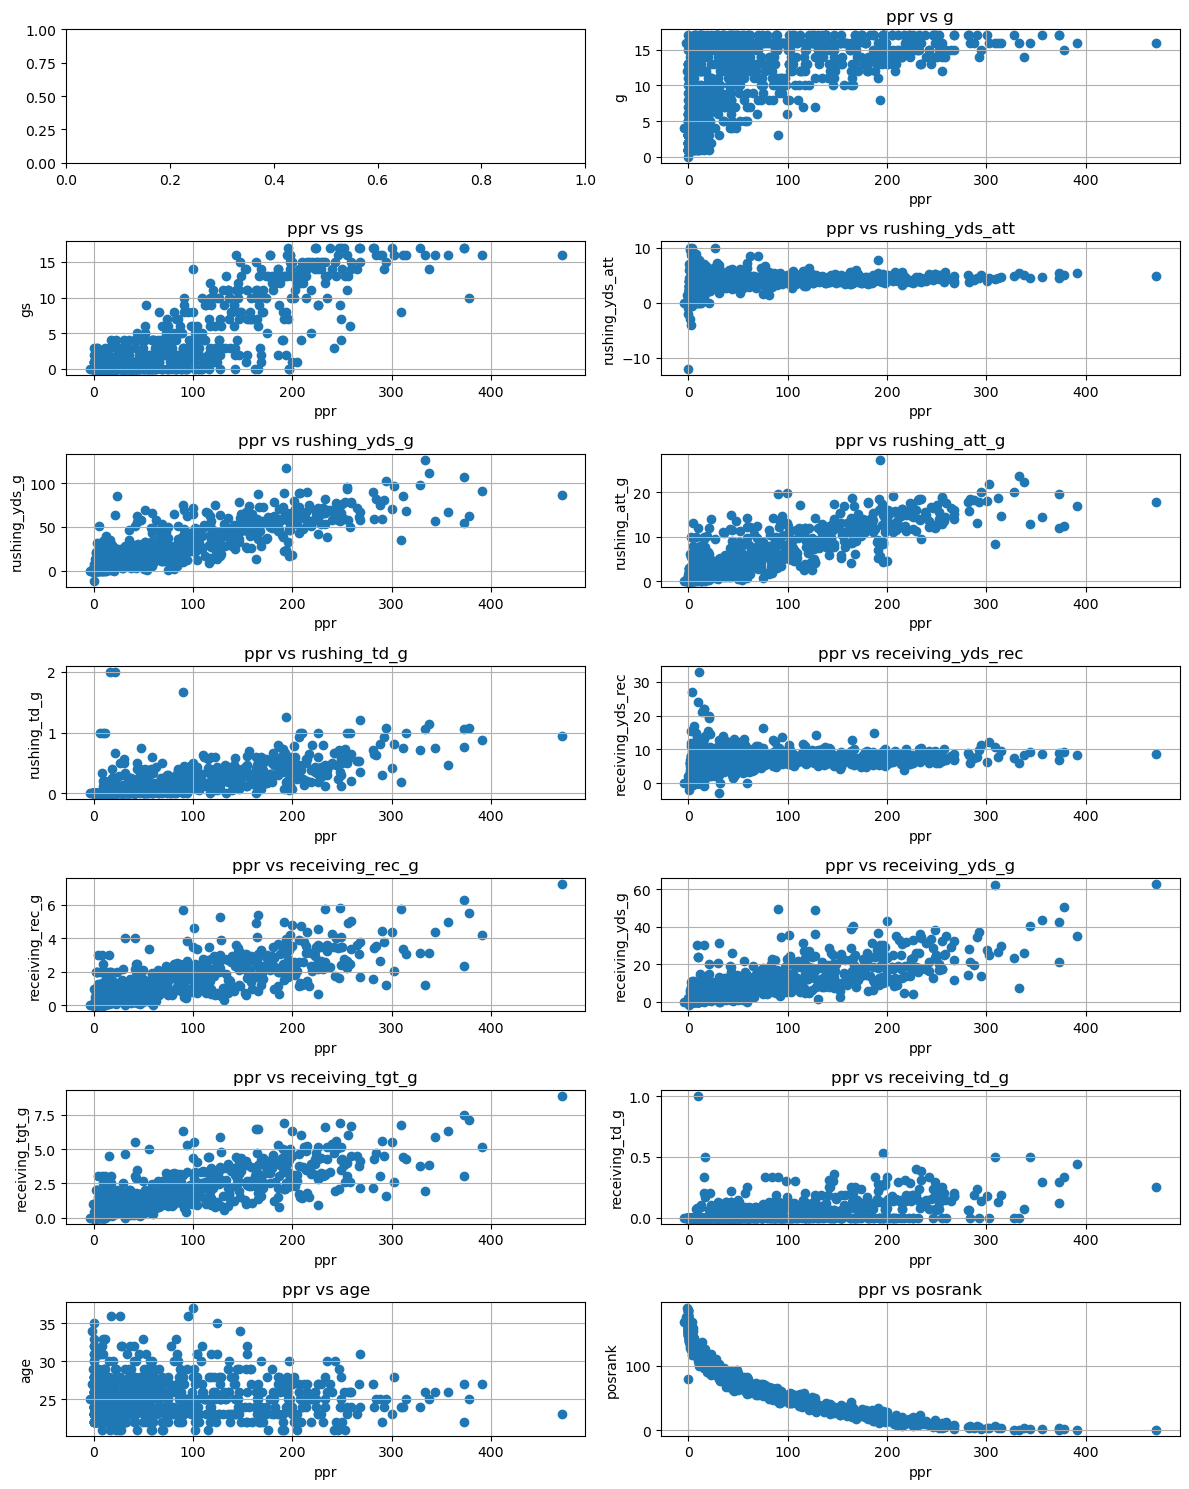

In [9]:
# Select the column for which scatterplots will be created
selected_column = 'ppr'
rb_scatter = rb_g.iloc[:,1:15] #exclude the players name column

num_cols = len(rb_scatter.columns) - 1
num_rows = num_cols // 2 if num_cols % 2 == 0 else num_cols // 2 + 1

# Create scatterplots in a grid
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 15))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

for i, column in enumerate(rb_scatter.columns):
    if column != selected_column:
        ax = axes[i]
        ax.scatter(rb_scatter[selected_column], rb_scatter[column])
        ax.set_title(f'{selected_column} vs {column}')
        ax.set_xlabel(selected_column)
        ax.set_ylabel(column)
        ax.grid(True)


plt.tight_layout()
plt.show()

In [10]:
#for players that started at least a game, the percentiles are much different
rb.loc[rb['gs']>0]['ppr'].describe()

count    402.000000
mean     128.888557
std       86.785909
min        0.000000
25%       57.525000
50%      117.850000
75%      191.325000
max      471.200000
Name: ppr, dtype: float64

In [11]:
#remove outliers

#There is a large cluster of players between 0-100 ppr that the model is having trouble predicting. For this model, remove them
rb_g = rb_g.loc[rb_g['ppr']>100]

#remove outlier ppr players based on IQR
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

#create loop to run on list of columns. including columns were major outliers were noticed in scatter plots
for column in rb_g.loc[:,['ppr']]:
    rb_g = remove_outliers_iqr(rb_g,column)

#due to non-linear scatter plots, apply transformations to metrics. apply log to dependant variable
rb_g['g_log'] = np.log(rb_g['g'])
rb_g['gs_sqrt'] = np.sqrt(rb_g['gs'])
rb_g['rushing_td_g_sqrt'] = np.sqrt(rb_g['rushing_td_g'])
rb_g['rushing_yds_att_log'] = np.log(rb_g['rushing_yds_att'])
rb_g['rushing_yds_g_log'] = np.log(rb_g['rushing_yds_g'])
rb_g['rushing_att_g_log'] = np.log(rb_g['rushing_att_g'])
rb_g['receiving_td_g_sqrt'] = np.sqrt(rb_g['receiving_td_g'])
rb_g['receiving_tgt_g_log'] = np.log(rb_g['receiving_tgt_g'])
rb_g['receiving_rec_g_log'] = np.log(rb_g['receiving_rec_g'])
rb_g['receiving_yds_g_log'] = np.log(rb_g['receiving_yds_g'])
rb_g['receiving_yds_rec_log'] = np.log(rb_g['receiving_yds_rec'])
rb_g['ppr_log'] = np.log(rb_g['ppr'])

#Regression

In [12]:
X = rb_g.iloc[:,np.r_[13:26]]
y = rb_g['ppr_log']
X = sm.add_constant(X)

result = sm.OLS(y,X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                ppr_log   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     522.3
Date:                Sat, 16 Mar 2024   Prob (F-statistic):          6.53e-159
Time:                        13:33:57   Log-Likelihood:                 349.03
No. Observations:                 237   AIC:                            -670.1
Df Residuals:                     223   BIC:                            -621.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.77

#Create Model

In [13]:
#create the model. ensure the training and test data return similar r2 scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)

print(model.score(X_train, y_train),model.score(X_test, y_test))

0.9689104853700259 0.9602411997621512


In [14]:
#print the independent variables and their corresponding coefficients
coef = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(model.coef_)],axis=1)
coef.columns = ['variable','coef']
coef

,variable,coef
0,const,0.000000
1,age,0.002321
2,posrank,-0.015385
3,g_log,0.347404
4,gs_sqrt,0.003631
5,rushing_td_g_sqrt,0.148774
6,rushing_yds_att_log,-4.566196
7,rushing_yds_g_log,4.653841
8,rushing_att_g_log,-4.608980
9,receiving_td_g_sqrt,0.032032


In [15]:
model.intercept_

3.971745986987939

#Model Evaluation

The R2 score of .96 is quite high. This is good, assuming all parts of the model check out. 

The MSE and RMSE can be used to compare this model against future varations and other similar models.

In [16]:
#calculate the r2 score
print("R2 Score:",model.score(X_test, y_test))

#create prediction values
y_pred = model.predict(X_test)

#return mse and rmse
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

R2 Score: 0.9602411997621512
Mean Squared Error: 0.0032278850564092317
Root Mean Squared Error: 0.05681447928485512


To check for overfitting, we can perform a cross-validation.

The scores of the 5 folds are pretty similar, indicating this model isn't currently overfit on the training data.

In [17]:
# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # 5-fold cross-validation

# Print R-squared scores for each fold
print("R-squared scores for each fold:", scores)

# Print mean R-squared score and standard deviation
print("Mean R-squared score:", np.mean(scores))
print("Standard deviation of R-squared scores:", np.std(scores))

R-squared scores for each fold: [0.90064136 0.95855302 0.95458316 0.9716583  0.96111547]
Mean R-squared score: 0.9493102600146408
Standard deviation of R-squared scores: 0.024982759351917783


The residual plot shows a mostly random spread.

The histogram is mostly normal, with a very slight right skew.

The predicted and test value scatter plot is mostly linear, showing that the predicted values are close to the test values.

All in all, the model looks to pass the visual evaluations.

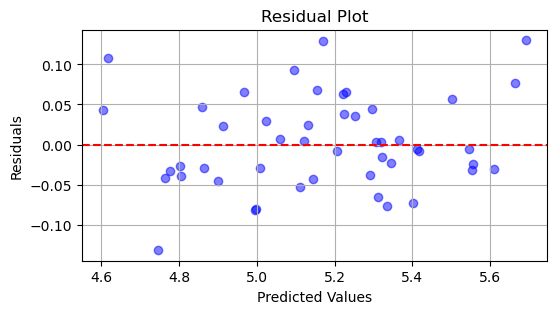

/Users/jcoombs/anaconda3/envs/fantasy-football/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


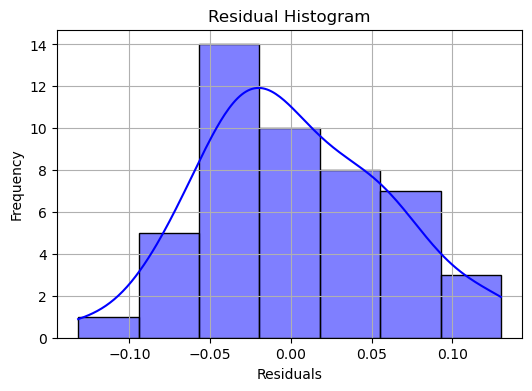

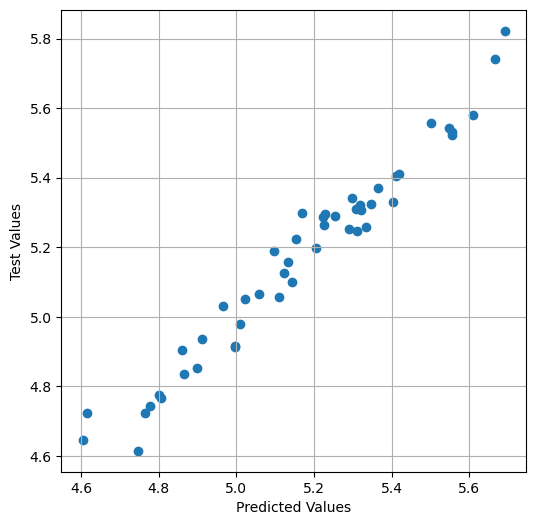

In [18]:
# Calculate residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(6, 3))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Residual histogram
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Prediction scattplot
plt.figure(figsize=(6, 6))
plt.scatter(y_pred,y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Test Values')
plt.grid(True)
plt.show()

#Export Model

In [20]:
filename = 'running_backs.sav'
pickle.dump(model, open(filename, 'wb'))